<a href="https://colab.research.google.com/github/mohsenfaghih13/AOD/blob/main/AOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0, Total Loss: 0.312282 | PDE: 4.76e-04 | IC: 2.99e-01 | BC: 1.31e-02
Epoch 100, Total Loss: 0.145259 | PDE: 2.51e-03 | IC: 1.10e-01 | BC: 3.28e-02
Epoch 200, Total Loss: 0.141107 | PDE: 3.21e-03 | IC: 1.06e-01 | BC: 3.17e-02
Epoch 300, Total Loss: 0.127465 | PDE: 3.92e-03 | IC: 9.42e-02 | BC: 2.93e-02
Epoch 400, Total Loss: 0.101509 | PDE: 5.31e-03 | IC: 6.56e-02 | BC: 3.06e-02
Epoch 500, Total Loss: 0.083118 | PDE: 6.15e-03 | IC: 4.71e-02 | BC: 2.99e-02
Epoch 600, Total Loss: 0.059231 | PDE: 4.20e-03 | IC: 2.48e-02 | BC: 3.03e-02
Epoch 700, Total Loss: 0.048208 | PDE: 4.10e-03 | IC: 1.08e-02 | BC: 3.34e-02
Epoch 800, Total Loss: 0.046359 | PDE: 4.10e-03 | IC: 9.04e-03 | BC: 3.32e-02
Epoch 900, Total Loss: 0.045615 | PDE: 4.31e-03 | IC: 9.13e-03 | BC: 3.22e-02


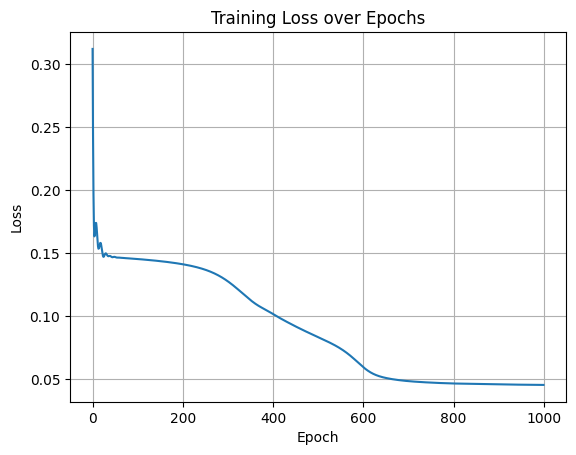

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

# 1. Define PINN model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, xyt):
        return self.net(xyt)

# 2. Compute derivatives using autograd
def derivatives(u, xyt):
    grad_u = autograd.grad(u, xyt, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grad_u[:, 0:1]
    u_y = grad_u[:, 1:2]
    u_t = grad_u[:, 2:3]

    u_xx = autograd.grad(u_x, xyt, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = autograd.grad(u_y, xyt, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]

    return u_t, u_x, u_y, u_xx, u_yy

# 3. PDE residual: u_t + v_x u_x + v_y u_y - D (u_xx + u_yy)
def pde_residual(model, xyt, vx=1.0, vy=0.5, D=0.01):
    u = model(xyt) #N point with xyt
    u_t, u_x, u_y, u_xx, u_yy = derivatives(u, xyt)
    return u_t + vx * u_x + vy * u_y - D * (u_xx + u_yy)

# 4. Generate training data
def gen_data(Nf=1000, Nic=200, Nbc=200):
    def rand_xy(N):
        x = torch.rand(N, 1)
        y = torch.rand(N, 1)
        return x, y

    def rand_t(N):
        return torch.rand(N, 1)

    def zeros_t(N):
        return torch.zeros(N, 1)

    # Interior points
    xf, yf = rand_xy(Nf)
    tf = rand_t(Nf)
    xyt_f = torch.cat([xf, yf, tf], dim=1).requires_grad_()

    # Initial condition (t = 0)
    x0, y0 = rand_xy(Nic)
    t0 = zeros_t(Nic)
    xyt_ic = torch.cat([x0, y0, t0], dim=1).requires_grad_()
    u_ic = torch.sin(torch.pi * x0) * torch.sin(torch.pi * y0)

    # Boundary conditions for all edges
    tb = rand_t(Nbc)

    # x = 0 and x = 1
    y_b1 = torch.rand(Nbc, 1)
    bc1 = torch.cat([torch.zeros(Nbc, 1), y_b1, tb], dim=1)  # x = 0
    bc2 = torch.cat([torch.ones(Nbc, 1), y_b1, tb], dim=1)   # x = 1

    # y = 0 and y = 1
    x_b2 = torch.rand(Nbc, 1)
    bc3 = torch.cat([x_b2, torch.zeros(Nbc, 1), tb], dim=1)  # y = 0
    bc4 = torch.cat([x_b2, torch.ones(Nbc, 1), tb], dim=1)   # y = 1

    xyt_bc = torch.cat([bc1, bc2, bc3, bc4], dim=0).requires_grad_()

    return xyt_f, xyt_ic, u_ic, xyt_bc

# 5. Training
model = PINN()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

xyt_f, xyt_ic, u_ic, xyt_bc = gen_data()

loss_log = []
for epoch in range(1000):
    opt.zero_grad()

    f = pde_residual(model, xyt_f)
    u_pred_ic = model(xyt_ic)
    u_pred_bc = model(xyt_bc)

    loss_pde = (f**2).mean()
    loss_ic = ((u_pred_ic - u_ic)**2).mean()
    loss_bc = (u_pred_bc**2).mean()

    loss = loss_pde + loss_ic + loss_bc
    loss.backward()
    opt.step()

    loss_log.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.6f} | PDE: {loss_pde.item():.2e} | IC: {loss_ic.item():.2e} | BC: {loss_bc.item():.2e}")

# 6. Plot training loss
plt.plot(loss_log)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()
